#### [fasster](https://github.com/tidyverts/fasster)

https://mitchelloharawild.com/melburn17/#74

Special DLM components can be specified using special functions defined below:

- `seas(s)`: Creates seasonal factors with seasonality s

- `trig(s)`: Creates seasonal fourier terms with seasonality s

- `poly(n)`: Creates a polynomial of order n (poly(1) creates a level, poly(2) creates a trend)

- `ARMA(ar, ma)`: Creates ARMA terms with coefficient vectors ar and ma

- `custom(dlm)`: Creates a custom dlm structure, using dlm



In [1]:
gdp_agg <- read.csv(file="data/eu_gdp_eu28.csv", header=TRUE, sep=",")

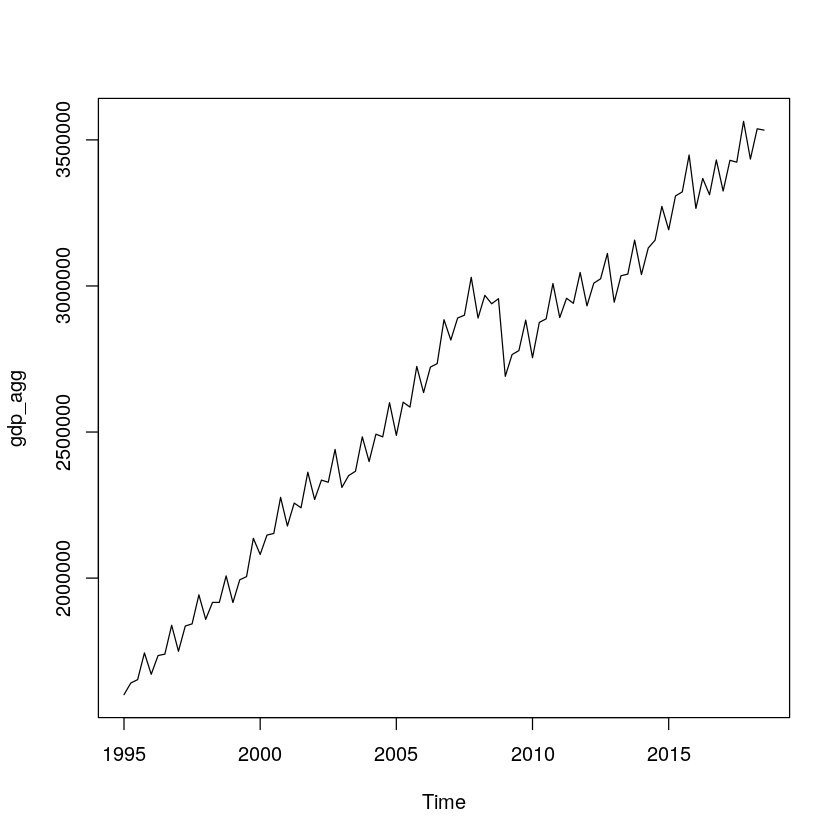

In [2]:
gdp_agg  <- ts(gdp_agg$values, frequency = 4, start = 1995) 
plot(gdp_agg)

In [3]:
train <- window(gdp_agg, end=c(2016,4))
test <- window(gdp_agg, start=c(2017,1))

The model parameters are estimated using the following heuristic:

- Filter the data using the specified model with non-zero state variances

- Obtain smoothed states $(θ^{(s)}t=θ_t|D_T)$ to approximate correct behaviour

- The initial state parameters taken from the first smoothed state: $m_0=E(θ^{(s)}_0), C_0=Var(θ^{(s)}_0)$

- Obtain state noise variances from the smoothed variance of $w_t: W=Var(w^{(s)}_t)=Var(θ^{(s)}_t−Gθ^{(s)}_{t−1}) $

- Obtain measurement noise variance from smoothed variance of $v_t: V=Var(v^{(s)}_t)=Var(y_t−F_tθ^{(s)}_t)$

- Repair restricted state variances for seasonal factors and ARMA terms



In [4]:
library(fasster)
library(dplyr)

Loading required package: fablelite

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [5]:
time_count  <- seq(1, length(train), by=1)

In [6]:
train_in_diff = train %>% 
  as_tsibble %>% mutate(d_value = value - lag(value))  %>% mutate(time_count)  #%>% filter(index >= "2010-01-01")
fit = train %>% as_tsibble() %>%
  model(fasster = FASSTER(value ~ poly(1) + trig(4) + 1))
fit_in_diff = train_in_diff %>%
  model(fasster = FASSTER(d_value ~ poly(1) + trig(4)))


fit %>% summary 

           Length Class  Mode   
dlm         11    dlm    list   
dlm_future  11    dlm    list   
est          4    tbl_ts list   
states     440    -none- numeric


In [7]:
fit %>% components() %>% tail()

.model,index,value,(Intercept),poly(1),trig(4)
fasster,2015 Q3,3322218,833059.5,2427391,-16894.173
fasster,2015 Q4,3448333,833059.5,2467757,74708.744
fasster,2016 Q1,3265629,833059.5,2505120,-59472.479
fasster,2016 Q2,3368178,833059.5,2498409,1657.908
fasster,2016 Q3,3312360,833059.5,2516396,-16894.173
fasster,2016 Q4,3431287,833059.5,2506030,74708.744


In [8]:
head(train_in_diff)

index,value,d_value,time_count
1995 Q1,1600924,NA,1
1995 Q2,1640884,39960.8,2
1995 Q3,1652305,11420.7,3
1995 Q4,1743835,91529.9,4
1996 Q1,1670650,-73184.6,5
1996 Q2,1734794,64143.5,6


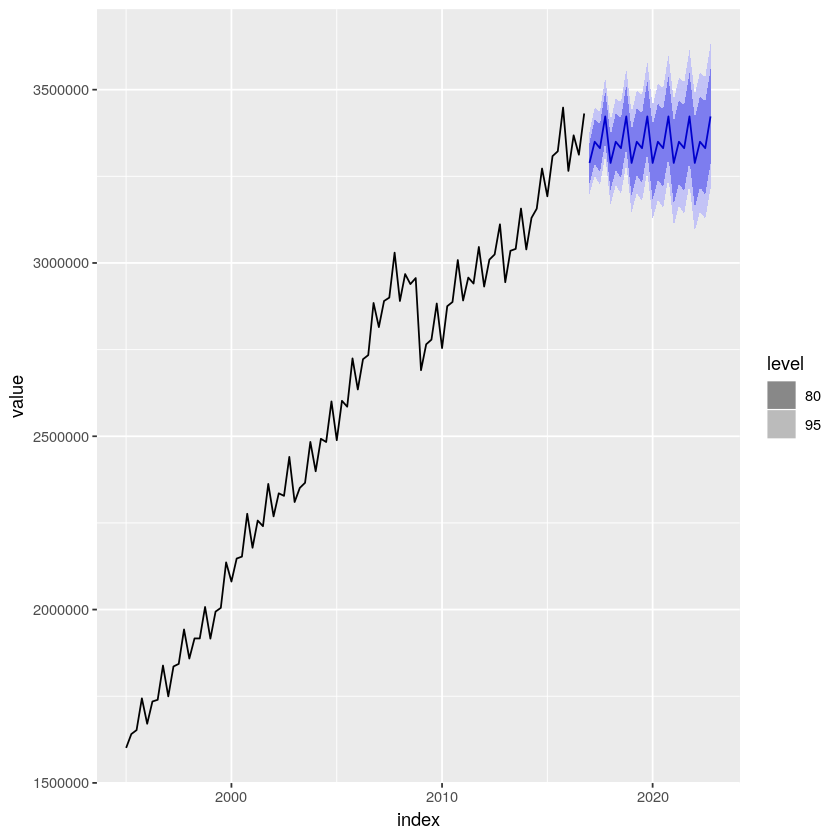

In [9]:
gdp_fasster_in_diff  <- fit_in_diff %>% 
  forecast(h=24)
gdp_fasster  <- fit %>% 
  forecast(h=24)

autoplot(gdp_fasster, train_in_diff)

Warning message:
“Removed 1 rows containing missing values (geom_path).”

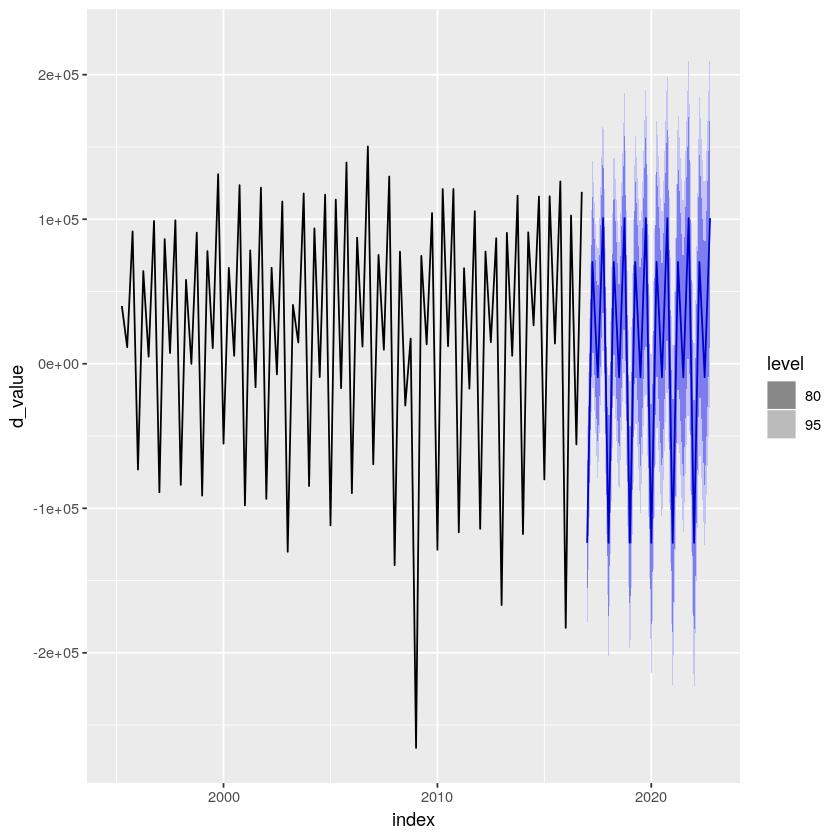

In [10]:
autoplot(gdp_fasster_in_diff, train_in_diff)

In [11]:
fit_time  <-  train_in_diff %>%
  model(fasster = FASSTER(value ~ poly(1) + trig(4) + time_count)) #+ time_count^2))
fit_time %>% summary 

           Length Class  Mode   
dlm         11    dlm    list   
dlm_future  11    dlm    list   
est          4    tbl_ts list   
states     440    -none- numeric


In [12]:
fit_time %>% components() %>% tail()

.model,index,value,poly(1),time_count,trig(4)
fasster,2015 Q3,3322218,1645379,19911.68,-17308.237
fasster,2015 Q4,3448333,1666257,19911.68,73466.547
fasster,2016 Q1,3265629,1684392,19911.68,-58230.283
fasster,2016 Q2,3368178,1657702,19911.68,2071.973
fasster,2016 Q3,3312360,1655689,19911.68,-17308.237
fasster,2016 Q4,3431287,1626326,19911.68,73466.547


In [13]:
gdp_fasster_time  <- fit_time %>% 
  forecast(h=24)

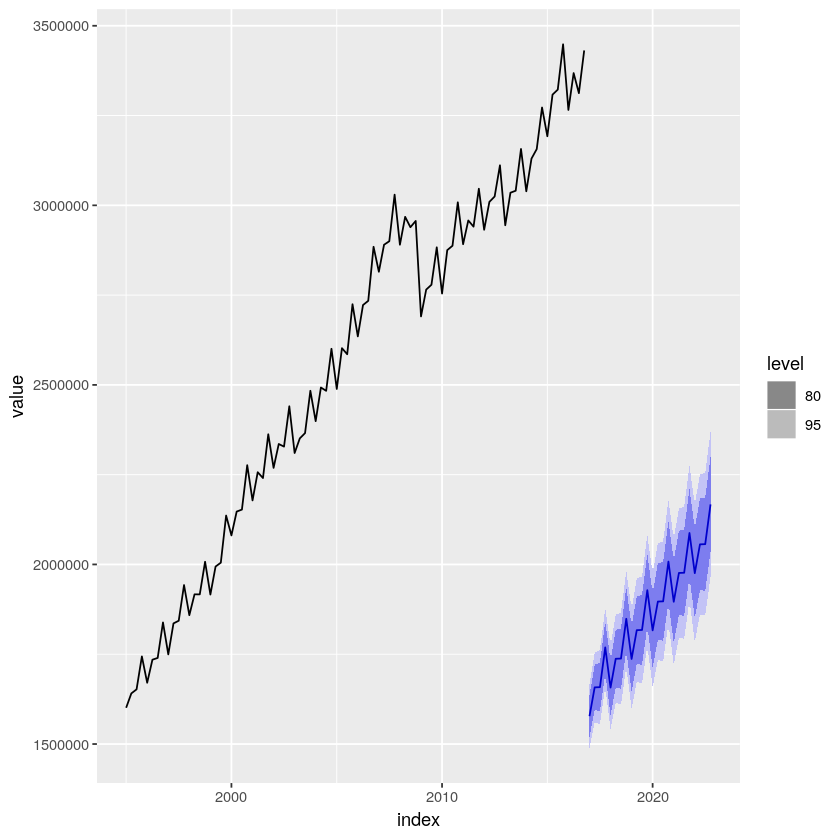

In [14]:
autoplot(gdp_fasster_time, train_in_diff)

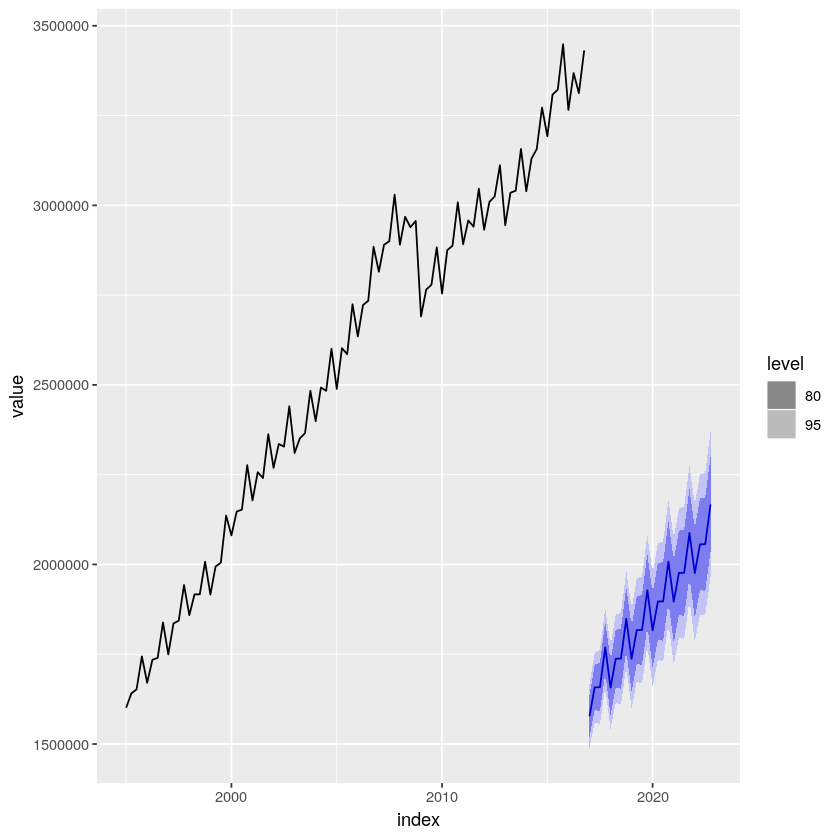

In [15]:
fit_time_int  <-  train_in_diff %>%
  model(fasster = FASSTER(value ~ poly(1) + trig(4) + time_count + 1)) #+ time_count^2))
gdp_fasster_time_int  <- fit_time_int %>% 
  forecast(h=24)

autoplot(gdp_fasster_time_int, train_in_diff)

In [16]:
fit_time_int %>% components() %>% tail()

.model,index,value,(Intercept),poly(1),time_count,trig(4)
fasster,2015 Q3,3322218,809862.7,835516.2,19911.67,-17308.237
fasster,2015 Q4,3448333,809862.7,856394.0,19911.67,73466.550
fasster,2016 Q1,3265629,809862.7,874529.2,19911.67,-58230.285
fasster,2016 Q2,3368178,809862.7,847839.3,19911.67,2071.973
fasster,2016 Q3,3312360,809862.7,845826.0,19911.67,-17308.237
fasster,2016 Q4,3431287,809862.7,816463.0,19911.67,73466.550


In [17]:
fit_time_2  <-  train_in_diff %>%
  model(fasster = FASSTER(value ~ poly(2) + trig(4) + time_count)) #+ time_count^2))
gdp_fasster_time_2  <- fit_time_2 %>% 
  forecast(h=24)

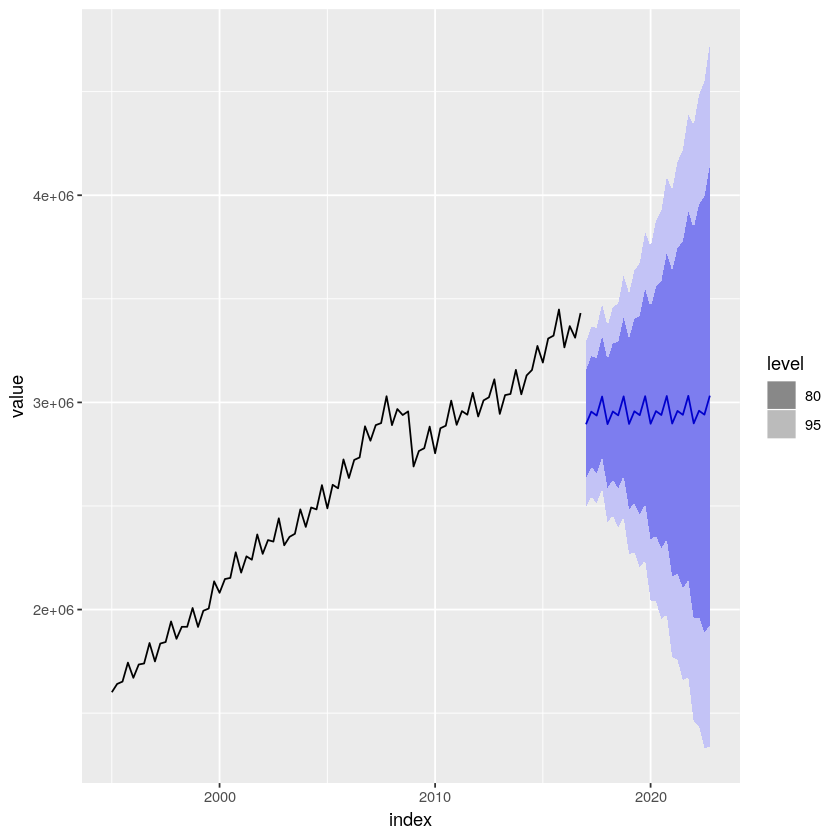

In [18]:
autoplot(gdp_fasster_time_2, train_in_diff)

In [19]:
fit_time_3  <-  train_in_diff %>%
  model(fasster = FASSTER(value ~ poly(2) + trig(4) + time_count + time_count^2))
gdp_fasster_time_3  <- fit_time_3 %>% 
  forecast(h=24)

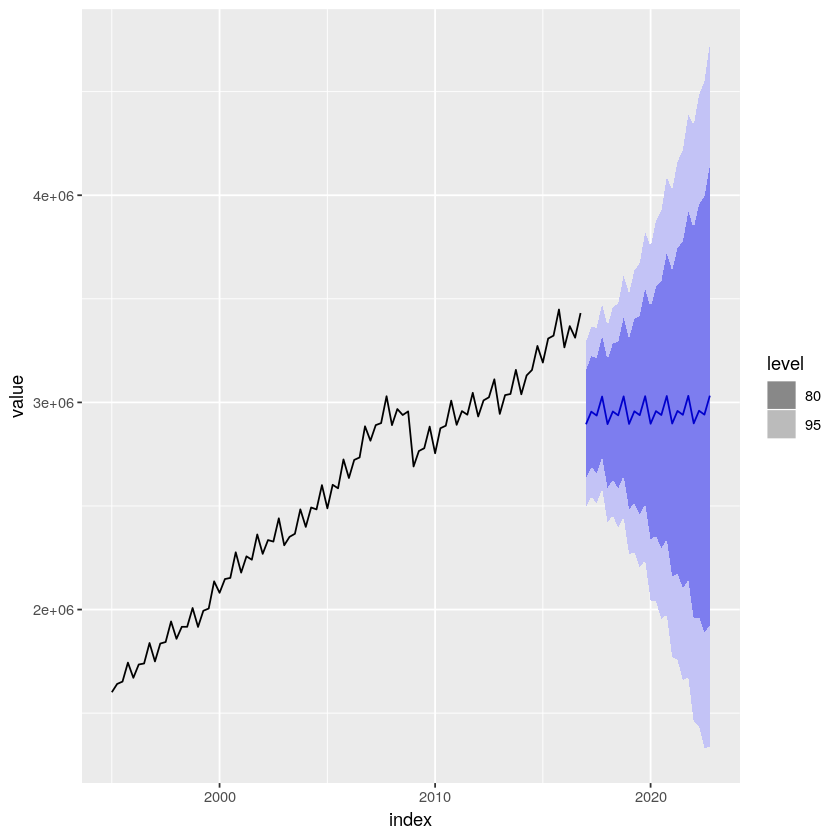

In [20]:
autoplot(gdp_fasster_time_3, train_in_diff)

In [21]:
library(forecast)
library(ggplot2)


Attaching package: ‘forecast’

The following objects are masked from ‘package:fablelite’:

    accuracy, forecast, geom_forecast, GeomForecast, StatForecast



In [22]:
19911.68 * 88

[1] 1752228

In [23]:
gdp_fasster_time$value

[1] 1577571 1657785 1658317 1769003 1657218 1737432 1737963 1848650 1736865
[10] 1817079 1817610 1928297 1816511 1896725 1897257 2007943 1896158 1976372
[19] 1976904 2087590 1975805 2056019 2056550 2167237

In [24]:
accuracy((gdp_fasster_time$value + 19911.68 * 88)[1:7], test)

,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,26834.81,32189.85,28195.65,0.763611,0.804538,0.1710553,0.3509691


In [25]:
gdp_arima  <- forecast(auto.arima(train), h=7)
accuracy(gdp_arima, test)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,496.5713,27093.45,18745.11,0.04021781,0.7075616,0.1917542,-0.006078177,NA
Test set,53108.4852,54480.16,53108.49,1.52742685,1.5274268,0.5432766,0.574894662,0.5760742


In [26]:
test

        Qtr1    Qtr2    Qtr3    Qtr4
2017 3325036 3430170 3423832 3563620
2018 3434383 3538041 3533647        

In [28]:
window(ts(gdp_fasster_time$value + 19911.68 * 88 , frequency = 4, start = 2017), end =c(2018,3))

        Qtr1    Qtr2    Qtr3    Qtr4
2017 3329799 3410013 3410545 3521231
2018 3409446 3489660 3490191        

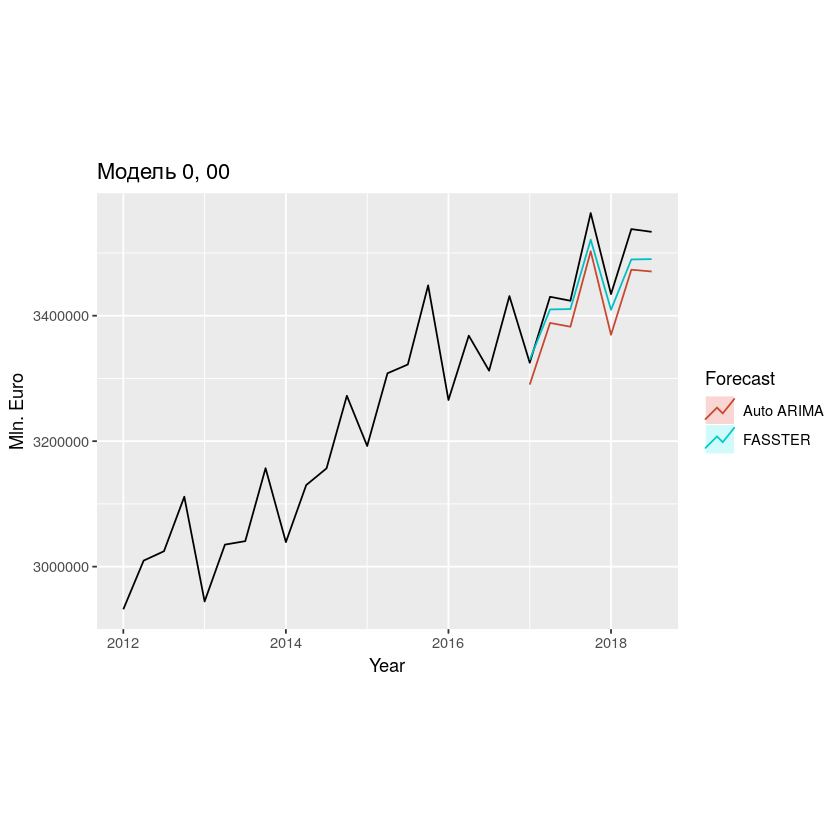

In [27]:
autoplot(window(gdp_agg, start=2012)) +
    autolayer(window(ts(gdp_fasster_time$value + 19911.68 * 88 , frequency = 4, start = 2017), end =c(2018,3))  , series="FASSTER") +
    autolayer(gdp_arima, series="Auto ARIMA", PI=FALSE) +
    xlab("Year") + ylab("Mln. Euro") +
    ggtitle("Модель 0, 00") +
    guides(colour=guide_legend(title="Forecast")) +
    theme(aspect.ratio = 0.75)